In [2]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

import cvxopt as opt
from cvxopt import blas, solvers

/opt/homebrew/Caskroom/miniforge/base/envs/thesis_2/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
# Define the assets and key initial metrics as investment amount to generate a portfolio


stocks = ['DHR','GILD','ISRG','JNJ','LLY','PFE','REGN','TMO','AZN','MRK']
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [1/len(stocks)]*len(stocks)        # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2009-01-01'              # Start date for asset data download
live_date = '2015-01-01'                # Portfolio LIVE start date (for analytics)
end_date  ='2015-12-25'

# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
weight = round(sum((np.array(weights))))
if weight != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


In [4]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  10 of 10 completed


In [5]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2009-01-02,5495.0,5109.0,6797.0,2544.0,3912.0,10117.0,5347.0,2965.0,9201.0,5686.0


In [6]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Set the number of assets, assumed that 'df' is your DataFrame with historical prices.
df = stock_data.copy()
num_assets = len(df.columns)
stocks = df.columns

# Create an empty DataFrame to store the portfolio weights over time
optimal_weights_df = pd.DataFrame(index=df.index, columns=stocks)

# Set the window length for the rolling covariance calculation
window_length = 424 # Use 252 for approx one year of trading days

# Set the initial weights to be equal for all assets
initial_weights = np.array([1/num_assets]*num_assets)

for end_date in df.index[window_length:]:
    
    # Extract the window of data
    data_window = df.loc[:end_date].tail(window_length)
    
    # Calculate expected returns and covariance matrix for the window
    mu = expected_returns.mean_historical_return(data_window)
    S = risk_models.sample_cov(data_window)

    # Initialise and optimize the portfolio on the window of data
    ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))  # Set bounds to allow shorting
    raw_weights = ef.max_sharpe()  # Optimize for maximal Sharpe ratio
    cleaned_weights = ef.clean_weights()  # Clean the raw weights
    
    # Add the weights to our optimal_weights dataframe
    optimal_weights_df.loc[end_date] = [cleaned_weights.get(stock) for stock in stocks]

# Forward fill the weights for the days we aren't rebalancing
optimal_weights_df = optimal_weights_df.fillna(method='ffill')

# Print out the final DataFrame
print(optimal_weights_df.tail())


                DHR  GILD     ISRG  JNJ      LLY  PFE     REGN  TMO  AZN  MRK
Date                                                                         
2015-12-18  0.02401   0.0  0.01604  0.0  0.49252  0.0  0.46743  0.0  0.0  0.0
2015-12-21  0.13715   0.0  0.03184  0.0  0.44655  0.0  0.38446  0.0  0.0  0.0
2015-12-22  0.07619   0.0  0.06300  0.0  0.47649  0.0  0.38432  0.0  0.0  0.0
2015-12-23  0.19238   0.0  0.02077  0.0  0.47912  0.0  0.30772  0.0  0.0  0.0
2015-12-24  0.06883   0.0  0.23600  0.0  0.39154  0.0  0.30363  0.0  0.0  0.0


In [7]:
optimal_weights_df

,DHR,GILD,ISRG,JNJ,LLY,PFE,REGN,TMO,AZN,MRK
Date,,,,,,,,,,
2009-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,0.02401,0.0,0.01604,0.0,0.49252,0.0,0.46743,0.0,0.0,0.0
2015-12-21,0.13715,0.0,0.03184,0.0,0.44655,0.0,0.38446,0.0,0.0,0.0
2015-12-22,0.07619,0.0,0.06300,0.0,0.47649,0.0,0.38432,0.0,0.0,0.0


In [8]:
start_date = df.index[window_length]
stock_data = stock_data.loc[start_date:]
shares_df = shares_df.loc[start_date:]
optimal_weights_df = optimal_weights_df.loc[start_date:]


In [9]:
shares_df

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares


In [10]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

,DHR_shares,GILD_shares,ISRG_shares,JNJ_shares,LLY_shares,PFE_shares,REGN_shares,TMO_shares,AZN_shares,MRK_shares
2010-09-09,4007.0,7830.0,3181.0,2431.0,4096.0,10143.0,4065.0,2290.0,6562.0,4536.0


In [11]:
# initialize variables
balance_year = stock_data.index[0].year
balance_month = stock_data.index[0].month
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.month != balance_month:
        signal = True

        # get the weights for the current period
        weights = optimal_weights_df.loc[day]

        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares

        balance_year = day.year
        balance_month = day.month
        count += 1

        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]

    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [12]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))

In [13]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [14]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [15]:
stock_data.filter(regex='weight')

,DHR_weight,GILD_weight,ISRG_weight,JNJ_weight,LLY_weight,PFE_weight,REGN_weight,TMO_weight,AZN_weight,MRK_weight
Date,,,,,,,,,,
2010-09-10,0.099526,0.100280,0.098274,0.099528,0.100013,0.100585,0.101511,0.099481,0.099960,0.100841
2010-09-13,0.100481,0.099706,0.097478,0.099519,0.099721,0.099891,0.102896,0.100679,0.099503,0.100126
2010-09-14,0.099803,0.099403,0.099114,0.099298,0.099406,0.099885,0.102307,0.100409,0.100076,0.100298
2010-09-15,0.098914,0.099807,0.101274,0.099524,0.099004,0.100446,0.101829,0.100097,0.099380,0.099725
2010-09-16,0.099102,0.100070,0.100651,0.099806,0.098813,0.099756,0.102985,0.100073,0.099347,0.099398
...,...,...,...,...,...,...,...,...,...,...
2015-12-18,0.176782,0.016471,0.000000,0.000000,0.511957,0.000000,0.294791,0.000000,0.000000,0.000000
2015-12-21,0.178502,0.016573,0.000000,0.000000,0.517591,0.000000,0.287334,0.000000,0.000000,0.000000
2015-12-22,0.179455,0.016652,0.000000,0.000000,0.518112,0.000000,0.285781,0.000000,0.000000,0.000000


In [16]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [17]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [18]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


In [19]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()

[*********************100%***********************]  1 of 1 completed


In [20]:
# Data timezone unification for pyfolio valuation
if stock_data.index.tz is None:
    stock_data.index = stock_data.index.tz_localize('UTC')
else:
    stock_data.index = stock_data.index.tz_convert('UTC')

if benchmark_data.index.tz is None:
    benchmark_data.index = benchmark_data.index.tz_localize('UTC')
else:
    benchmark_data.index = benchmark_data.index.tz_convert('UTC')

# Convert live_date to a datetime object, then localize or convert as needed.
live_date = pd.to_datetime(live_date)
if live_date.tzinfo is None:
    live_date = live_date.tz_localize('UTC')
else:
    live_date = live_date.tz_convert('UTC')



Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.93,2011-04-28,2011-08-08,2011-09-06,94
1,25.25,2011-09-08,2011-11-18,2012-02-13,113
2,17.12,2012-06-06,2012-07-24,2012-10-16,95
3,15.00,2015-09-17,2015-10-21,NaT,NaN
4,14.77,2010-09-24,2011-01-28,2011-04-27,154


AttributeError: 'Axes' object has no attribute 'is_last_row'

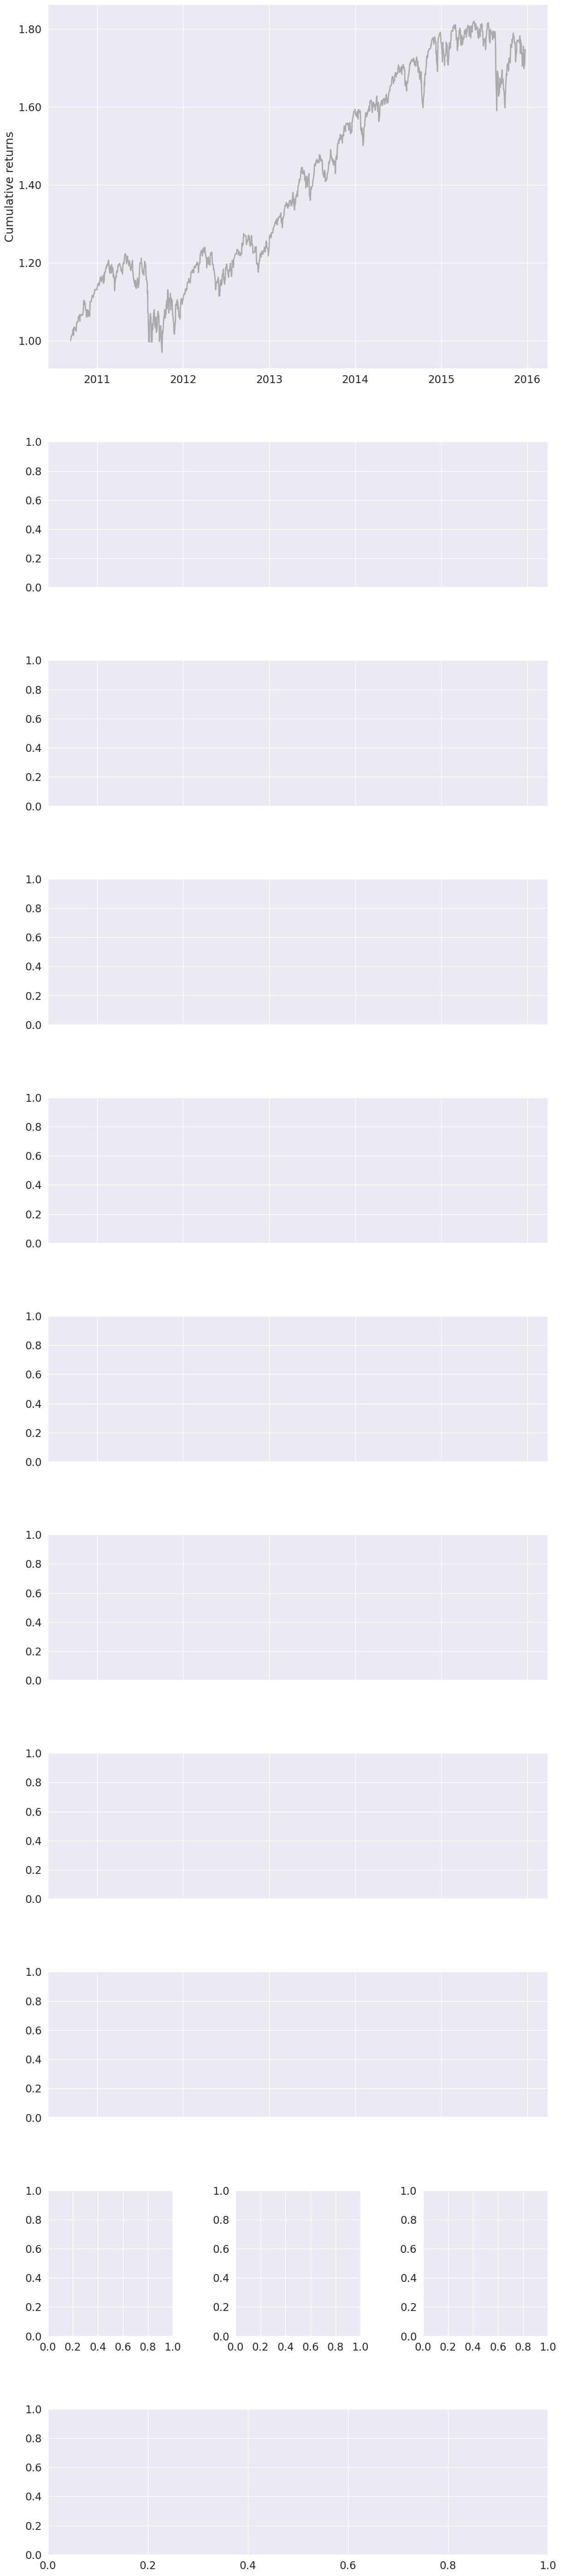

In [21]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)